# Reddit Project ML Script
## Reading the dataset

In [1]:
#!aws s3 ls s3://yc910-labdata-3/reddit_nlp/

In [2]:
#!aws s3 cp s3://yc910-labdata-3/reddit_nlp/ s3://yc910-labdata-4/reddit_nlp --recursive

In [3]:
#!aws s3 cp s3://yc910-labdata-3/reddit_ml/ s3://yc910-labdata-4/reddit_ml --recursive

In [4]:
#!aws s3 cp s3://yc910-labdata-3/reddit_eda/ s3://yc910-labdata-4/reddit_eda --recursive

In [5]:
#!aws s3 cp s3://yc910-labdata-3/covid/ s3://yc910-labdata-4/covid --recursive

In [6]:
#!aws s3 cp s3://yc910-labdata-3/nasdaq/ s3://yc910-labdata-4/nasdaq --recursive

In [7]:
import findspark
findspark.init()

In [8]:
import pyspark.sql.functions as f
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [9]:
spark = SparkSession.builder \
        .appName("reddit_ml") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.2") \
    .master('yarn') \
    .getOrCreate()

Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2760ec50-01ed-4ad9-b031-c6e2d5150f2e;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found

In [10]:
spark

In [14]:
df_full = spark.read.parquet('s3://yc910-labdata-3/reddit_nlp')

In [6]:
df_full.show(5)

22/04/20 02:50:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------+--------------+-------------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+------------+-----+--------+---------+-------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+--------+---------+---------+----+---+--------------------+--------------------+---------+
|         author|author_premium|  author_flair_text|author_fullname|                body|collapsed|controversiality|created_utc|gilded|no_follow|quarantined|score|send_replies|total_awards_received|len_body|      date|  month| score_group|covid|election|economics|finance|gender_equality|racial_equality|            document|          lemma_body|          clean_text|           word_list|government|eco_left|eco_right|eco_centr|auth|lib|      clean_document| sentence_embeddings|sentiment|
+---------------+---

In [7]:
df_full.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_premium: integer (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- body: string (nullable = true)
 |-- collapsed: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- no_follow: integer (nullable = true)
 |-- quarantined: integer (nullable = true)
 |-- score: long (nullable = true)
 |-- send_replies: integer (nullable = true)
 |-- total_awards_received: long (nullable = true)
 |-- len_body: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- month: string (nullable = true)
 |-- score_group: string (nullable = true)
 |-- covid: integer (nullable = true)
 |-- election: integer (nullable = true)
 |-- economics: integer (nullable = true)
 |-- finance: integer (nullable = true)
 |-- gender_equality: integer (nullable = true)
 |-- racial_equality: integer (n

## 1. Latent Dirichlet allocation
### 1.1. Calculate TF-IDF

In [11]:
!/mnt/miniconda/bin/pip install wordcloud

     |████████████████████████████████| 366 kB 27.5 MB/s eta 0:00:01


In [12]:
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import HashingTF, IDF, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from sklearn.manifold import TSNE

In [15]:
cv = CountVectorizer(inputCol="word_list", outputCol="TF", minDF=100, vocabSize=5000)
model = cv.fit(df_full)
df_tf = model.transform(df_full)

In [16]:
hashingTF = HashingTF(numFeatures=5000, inputCol="word_list", outputCol="TF")
df_tf = hashingTF.transform(df_full)
df_tf.cache()

22/04/27 21:09:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[author: string, author_premium: int, author_flair_text: string, author_fullname: string, body: string, collapsed: int, controversiality: bigint, created_utc: bigint, gilded: bigint, no_follow: int, quarantined: int, score: bigint, send_replies: int, total_awards_received: bigint, len_body: int, date: date, month: string, score_group: string, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemma_body: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, clean_text: string, word_list: array<string>, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, clean_document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence_embe

In [17]:
_IDF = IDF(inputCol="TF", outputCol="IDF", minDocFreq=100)
IDF_model = _IDF.fit(df_tf)
df_idf = IDF_model.transform(df_tf)

### 1.2. Train a LDA Model

In [18]:
# Trains a LDA model.
lda = LDA(k=5, maxIter=100, featuresCol = "IDF", seed = 502)
lda_model = lda.fit(df_idf)
lda_result = lda_model.transform(df_idf)

In [19]:
# Describe topics.
topics = lda_model.describeTopics(5)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

The topics described by their top-weighted terms:
+-----+------------------------------+---------------------------------------------------------------------------------------------------------------+
|topic|termIndices                   |termWeights                                                                                                    |
+-----+------------------------------+---------------------------------------------------------------------------------------------------------------+
|0    |[2040, 2514, 4344, 3525, 4263]|[0.006479617524006684, 0.006403224948072822, 0.006081585423390111, 0.0060751625296936425, 0.005173899073365339]|
|1    |[4263, 843, 3313, 68, 4344]   |[0.008273656329405339, 0.0068197084863825174, 0.005937379636426981, 0.005779317089146648, 0.005385765938160964]|
|2    |[2913, 4263, 912, 4841, 4610] |[0.008718457049856238, 0.007008670883880933, 0.006656109564013414, 0.0061616193569118, 0.0052577400683031725]  |
|3    |[3173, 1980, 4406, 2221, 2634]|[0.039

### 1.3. Use TSNE to plot the Distribution of Topics

In [20]:
tsne = TSNE(n_components=2,init="pca", learning_rate="auto", random_state=502)

In [21]:
df_lda_sample = lda_result.sample(fraction=0.0002,seed=502)

In [22]:
df_idf_sample = df_lda_sample.select("IDF").rdd.map(lambda row: row['IDF'].toArray()).collect()
df_idf_sample = pd.DataFrame(df_idf_sample)

tsne_idf = tsne.fit_transform(df_idf_sample)

/mnt/miniconda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [23]:
df_topic = df_lda_sample.select('topicDistribution').toPandas()
df_topic = df_topic.topicDistribution.apply(lambda x:np.array(x))
df_topic = pd.DataFrame(df_topic.tolist()).apply(lambda x:x.argmax(),axis=1)
df_topic = df_topic.reset_index()
df_topic.columns = ['doc','topic']

/usr/lib/spark/python/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


### Figure 1. The Distribution of Post Topic Using LDA, Sample Size = 1400 (0.0002)

In [29]:
tsne_idf = pd.DataFrame(tsne_idf)

In [31]:
tsne_idf.columns = ["TSNE Dim 1","TSNE Dim 2"]

In [35]:
df_topic.topic = df_topic.topic.astype("str")

<Figure size 864x720 with 0 Axes>

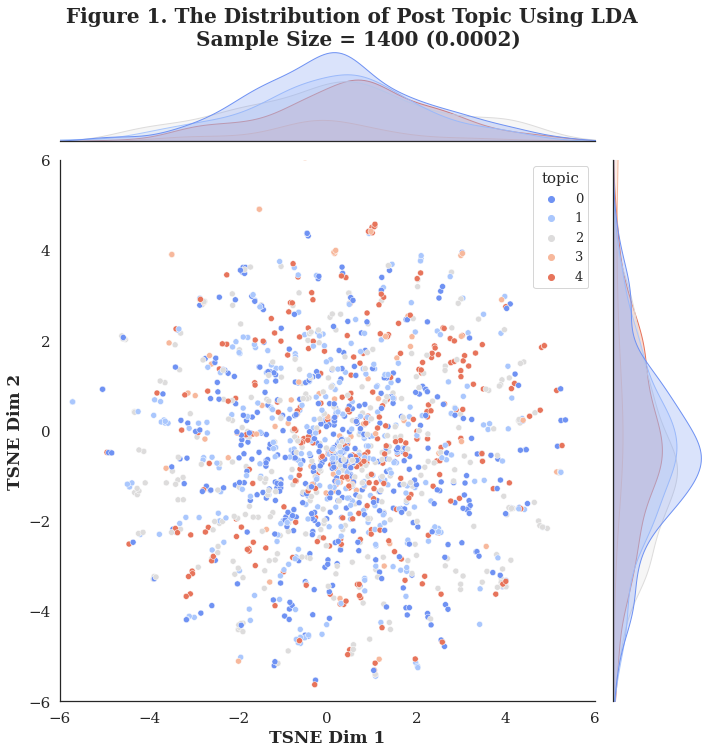

In [84]:
plt.figure(figsize=(12,10))
pal = sns.color_palette(palette="Paired", n_colors=11)[1::2]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif', 'xtick.labelsize': 15.0,
                     'ytick.labelsize': 15.0, 'legend.fontsize': 13.0,
                    'legend.title_fontsize': 15.0})

p = sns.jointplot(x="TSNE Dim 1", y="TSNE Dim 2", data=tsne_idf, 
                  hue=df_topic.topic, hue_order=["0","1","2","3","4"], 
                  kind="scatter", palette="coolwarm", 
                  height=10, xlim=(-6,6), ylim=(-6,6))

p.ax_joint.set_xlabel('TSNE Dim 1', fontweight='bold', fontsize = 17)
p.ax_joint.set_ylabel('TSNE Dim 2', fontweight='bold', fontsize = 17)
plt.title(label="Figure 1. The Distribution of Post Topic Using LDA \n Sample Size = 1400 (0.0002)", fontsize = 20, fontweight = "bold", y = 1.2, x=-2.8)

#p.set_title("Plot", fontsize = 20)

plt.show()

### 1.4. Wordcloud of Each Topic

In [42]:
topic_list = lda_model.describeTopics(100).collect()

In [43]:
cv_vocab = model.vocabulary

In [44]:
wordcloud_list = []
for topic in topic_list: 
    word_dict={}
    for i in range(100):
        word_dict[cv_vocab[topic.termIndices[i]]] = topic.termWeights[i]
    
    wordcloud_list.append(word_dict)

In [45]:
mask = np.array(Image.open("background.jpeg").convert("RGB"))
image_colors = ImageColorGenerator(mask)

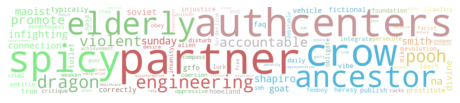

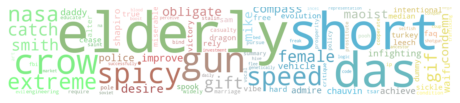

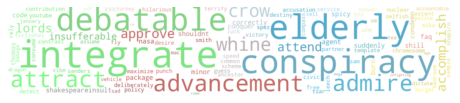

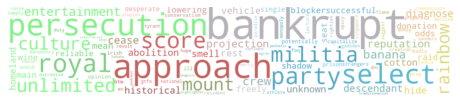

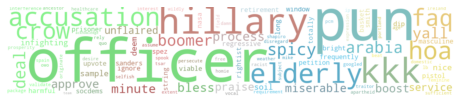

In [46]:
for wordcloud_dict in wordcloud_list:
    wordcloud_lda = WordCloud(background_color="white", mode="RGBA", mask=mask, max_words=100).generate_from_frequencies(wordcloud_dict)
    plt.figure(figsize=[8,8])
    plt.imshow(wordcloud_lda.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [47]:
from pyspark.sql.types import IntegerType
max_index = f.udf(lambda x: x.tolist().index(max(x)), IntegerType())

In [48]:
df_full = lda_result.withColumn("topic", max_index("topicDistribution"))

In [49]:
df_full.select("topicDistribution", "topic").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------+-----+
|topicDistribution                                                                                         |topic|
+----------------------------------------------------------------------------------------------------------+-----+
|[0.3883717264456554,0.0077322342443647005,0.5909166851597881,0.005572444377051874,0.0074069097731398565]  |2    |
|[0.9841726676096718,0.004253316244366067,0.004427998235960199,0.0030681508886614963,0.004077867021340454] |0    |
|[0.005267198966637228,0.004547661522363772,0.9825458307347525,0.003280920626713513,0.0043583881495328726] |2    |
|[8.321237650455275E-4,0.6584147064559014,0.03321059458233217,0.30685819354469446,6.843816520265372E-4]    |1    |
|[0.0024440631285377458,0.6569266565332962,0.0021785311676851453,0.0015084343936244372,0.33694231477685627]|1    |
+-------------------------------------------------------------------------------

In [50]:
df_full.groupBy("topic").count().sort("topic").show()

+-----+-------+
|topic|  count|
+-----+-------+
|    0|2148143|
|    1|1653916|
|    2|1799532|
|    3| 519049|
|    4|1599208|
+-----+-------+



In [21]:
summary_topic_sentiment = df_full.groupBy("topic").pivot("sentiment").count()

summary_topic_sentiment = summary_topic_sentiment.withColumn("pos_neg", col("negative")/col("positive"))

summary_topic_sentiment.show()

+-----+--------+-------+--------+-------------------+
|topic|negative|neutral|positive|            pos_neg|
+-----+--------+-------+--------+-------------------+
|    1|  602935|  82527|  968454| 0.6225747428375534|
|    3|  101015|  20099|  397935|0.25384799024966387|
|    4|  720093|  65155|  813960| 0.8846786082854194|
|    2|  696843|  87881| 1014808|  0.686674720735351|
|    0|  665753| 119084| 1363306|0.48833717448613884|
+-----+--------+-------+--------+-------------------+



In [51]:
df_full.write.parquet('s3://yc910-labdata-3/reddit_ml', mode="overwrite")

## 2. The Relation Between Sentiment and Author Flair Type and Other Dummy Variables
### 2.1. Data Subset

In [13]:
df_full = spark.read.parquet('s3://yc910-labdata-3/reddit_ml')

In [6]:
df_full.groupBy("sentiment").count().show()

22/04/21 18:05:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+-------+
|sentiment|  count|
+---------+-------+
| positive|4558463|
|  neutral| 374746|
| negative|2786639|
+---------+-------+



In [7]:
df_full.groupBy("author_flair_text").count().show(truncate=False)

+------------------------+-------+
|author_flair_text       |count  |
+------------------------+-------+
|auth-authcenter         |738773 |
|authright-authright     |621639 |
|right-right             |618667 |
|left-left               |638826 |
|authleft-authleft       |413811 |
|centrist-centrist       |854571 |
|lib-libcenter           |920231 |
|libright2-libright      |287179 |
|                        |267    |
|centrist-grandinquisitor|7601   |
|libright-libright       |1305766|
|politicalcompass        |3      |
|centg-centrist          |207000 |
|libleft-libleft         |1105514|
+------------------------+-------+



In [93]:
df_sub1 = df_full.filter((col("date")>="2020-01-01") & 
                         (col("date")<="2020-06-30") & 
                         (col("sentiment")!="neutral") &
                         (col("author_flair_text").isin(["", "centrist-grandinquisitor", "politicalcompass"]) == False))

In [94]:
df_sub1.groupBy("sentiment").count().show()

+---------+-------+
|sentiment|  count|
+---------+-------+
| positive|1087618|
| negative| 621385|
+---------+-------+



In [10]:
df_sub1.groupBy("author_flair_text").count().show(truncate=False)

+-------------------+------+
|author_flair_text  |count |
+-------------------+------+
|auth-authcenter    |158265|
|authright-authright|143810|
|right-right        |110414|
|left-left          |173051|
|authleft-authleft  |108608|
|centrist-centrist  |160765|
|lib-libcenter      |182115|
|libright2-libright |88046 |
|libright-libright  |283653|
|centg-centrist     |17754 |
|libleft-libleft    |282522|
+-------------------+------+



In [95]:
df_sub1 = df_sub1.withColumn("weekday", f.dayofweek("date"))

In [96]:
df_sub1 = df_sub1.withColumn("month", f.month("date"))

In [97]:
df_sub1 = df_sub1.select("author_flair_text","author_premium","controversiality","clean_text","sentiment","weekday","month",
                         "score","topic","covid","election","economics","finance","gender_equality",
                         "racial_equality","government","eco_left","eco_right","eco_centr","auth","lib")

In [98]:
df_sub1.show(5, truncate=False)

+-------------------+--------------+----------------+---------------------------------+---------+-------+-----+-----+-----+-----+--------+---------+-------+---------------+---------------+----------+--------+---------+---------+----+---+
|author_flair_text  |author_premium|controversiality|clean_text                       |sentiment|weekday|month|score|topic|covid|election|economics|finance|gender_equality|racial_equality|government|eco_left|eco_right|eco_centr|auth|lib|
+-------------------+--------------+----------------+---------------------------------+---------+-------+-----+-----+-----+-----+--------+---------+-------+---------------+---------------+----------+--------+---------+---------+----+---+
|authright-authright|0             |0               |hadrian roman emperor            |positive |6      |3    |6    |1    |0    |0       |0        |0      |0              |0              |0         |0       |0        |0        |0   |0  |
|libleft-libleft    |0             |0           

### 2.2. Split the Data

In [99]:
sub1_train, sub1_test, sub1_predict = df_sub1.randomSplit([0.8, 0.18, 0.02], seed=502)

In [100]:
print("Number of training records: " + str(sub1_train.count()))
print("Number of testing records : " + str(sub1_test.count()))
print("Number of prediction records : " + str(sub1_predict.count()))

Number of training records: 1367512


Number of testing records : 307395


Number of prediction records : 34096


### 2.3. Random Forest
### 2.3.1. Build a Pipeline and Train a Random Forest Model

In [101]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [102]:
stringindexer_flair = StringIndexer(inputCol="author_flair_text", outputCol="author_flair_ix")
stringindexer_sentiment = StringIndexer(inputCol="sentiment", outputCol="sentiment_ix")

In [103]:
y_labels = stringindexer_sentiment.fit(sub1_train).labels

In [104]:
vectorAssembler_features = VectorAssembler(
    inputCols=["author_flair_ix","author_premium","controversiality","score","topic","weekday","month",
               "covid","election","economics","finance","gender_equality",
               "racial_equality","government","eco_left","eco_right","eco_centr","auth","lib"], 
    outputCol= "features")

In [105]:
rf1 = RandomForestClassifier(labelCol="sentiment_ix", featuresCol="features",
                             numTrees=50, maxDepth=5, seed=502)

rf2 = RandomForestClassifier(labelCol="sentiment_ix", featuresCol="features", 
                             numTrees=100, maxDepth=5, seed=502)

rf3 = RandomForestClassifier(labelCol="sentiment_ix", featuresCol="features",  
                             numTrees=100, maxDepth=10, seed=502)

In [106]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predicted_sentiment", 
                               labels= y_labels)

In [107]:
pipeline_rf1 = Pipeline(stages=[stringindexer_flair, 
                               stringindexer_sentiment,  
                               vectorAssembler_features, 
                               rf1, 
                               labelConverter])

pipeline_rf2 = Pipeline(stages=[stringindexer_flair, 
                               stringindexer_sentiment,  
                               vectorAssembler_features, 
                               rf2, 
                               labelConverter])

pipeline_rf3 = Pipeline(stages=[stringindexer_flair, 
                               stringindexer_sentiment,  
                               vectorAssembler_features, 
                               rf3, 
                               labelConverter])

In [108]:
model_rf1 = pipeline_rf1.fit(sub1_train)
model_rf1.transform(sub1_train)

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

In [109]:
model_rf2 = pipeline_rf2.fit(sub1_train)
model_rf2.transform(sub1_train)

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

In [110]:
model_rf3 = pipeline_rf3.fit(sub1_train)
model_rf3.transform(sub1_train)

22/04/27 03:56:18 WARN DAGScheduler: Broadcasting large task binary with size 1835.3 KiB
22/04/27 03:56:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/04/27 03:56:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/04/27 03:56:46 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/04/27 03:56:49 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/04/27 03:57:06 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

### 2.3.2. Model Evaluation and Comparison

In [111]:
# Create both evaluators
evaluator_Mu = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction")
evaluator_Bi = BinaryClassificationEvaluator(labelCol="sentiment_ix", rawPredictionCol="prediction")

In [112]:
from sklearn.metrics import confusion_matrix
def model_eva(models, best, test, pred):
    eva = []
    for model in models:
        predictions = model.transform(test)
        acc = evaluator_Mu.evaluate(predictions, {evaluator_Mu.metricName: "accuracy"})
        f1 = evaluator_Mu.evaluate(predictions, {evaluator_Mu.metricName: "f1"})
        weightedPrecision = evaluator_Mu.evaluate(predictions, {evaluator_Mu.metricName: "weightedPrecision"})
        weightedRecall = evaluator_Mu.evaluate(predictions, {evaluator_Mu.metricName: "weightedRecall"})
        auc = evaluator_Bi.evaluate(predictions, {evaluator_Bi.metricName: "areaUnderROC"})
        eva.append([acc,f1,weightedPrecision,weightedRecall,auc])
        
    df_eva = pd.DataFrame(eva)
    df_eva.columns = ["accuracy", "f1", "weighted_precision", "weighted_recall", "auc"]
    
    predictions = best.transform(pred)
    y_pred=predictions.select("predicted_sentiment").collect()
    y_orig=predictions.select("sentiment").collect()
    cm = confusion_matrix(y_orig, y_pred)
    
    return df_eva,cm

In [113]:
rf_evaluation, rf_cm = model_eva([model_rf1, model_rf2, model_rf3], model_rf1, sub1_test, sub1_predict)

22/04/27 03:57:37 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/04/27 03:57:43 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/04/27 03:57:49 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/04/27 03:57:55 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/04/27 03:58:01 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


In [114]:
rf_evaluation.index = ["model1","model2","model3"]
rf_evaluation

,accuracy,f1,weighted_precision,weighted_recall,auc
model1,0.650232,0.556659,0.641602,0.650232,0.531957
model2,0.650329,0.556257,0.642534,0.650329,0.531818
model3,0.650739,0.556444,0.644396,0.650739,0.532105


In [115]:
print("Random Forest Confusion Matrix:")
print(rf_cm)

Random Forest Confusion Matrix:
[[ 1175 11203]
 [  693 21025]]


### 2.3.3. Feature Importance

In [116]:
rf_feature_imp = pd.DataFrame({"feature":model_rf1.stages[-3].getInputCols(), 
                               "importance":model_rf1.stages[-2].featureImportances.toArray().tolist()})\
                                .sort_values("importance",ascending = False).reset_index(drop=True)

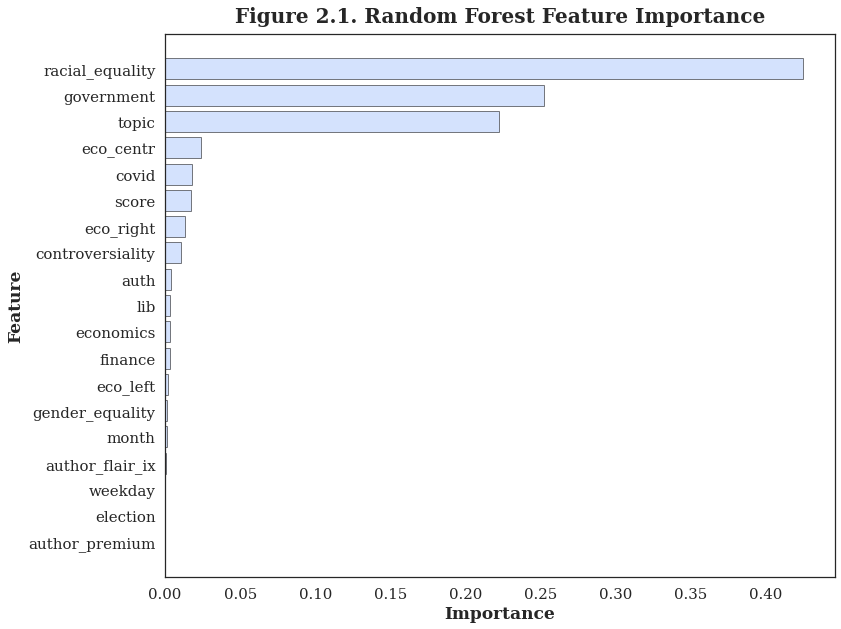

In [119]:
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})

fig, ax = plt.subplots(figsize=(12,10))
ax.barh(y = "feature", width = "importance", data = rf_feature_imp, edgecolor="black", color=pal[1], alpha=0.5)
ax.invert_yaxis()  

plt.title(label="Figure 2.1. Random Forest Feature Importance", fontsize = 20, fontweight = "bold", y = 1.01)
plt.xlabel(xlabel = "Importance", fontsize = 17, fontweight = "bold")
plt.ylabel(ylabel = "Feature", fontsize = 17, fontweight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

In [120]:
summary_gov_sentiment = df_full.groupBy("government").pivot("sentiment").count()

summary_gov_sentiment = summary_gov_sentiment.withColumn("pos_neg", col("negative")/col("positive"))

summary_gov_sentiment.show()

+----------+--------+-------+--------+------------------+
|government|negative|neutral|positive|           pos_neg|
+----------+--------+-------+--------+------------------+
|         1|  118341|   8633|   66747|1.7729785608341948|
|         0| 2668298| 366113| 4491716|0.5940486887416747|
+----------+--------+-------+--------+------------------+



### 2.3.4. Save Model

In [121]:
model_rf1.write().overwrite().save("s3://yc910-labdata-4/models/rf1")
model_rf2.write().overwrite().save("s3://yc910-labdata-4/models/rf2")
model_rf3.write().overwrite().save("s3://yc910-labdata-4/models/rf3")

In [124]:
## Test
from pyspark.ml import PipelineModel

model_rf_test = PipelineModel.load("s3://yc910-labdata-4/models/rf1")
test_eva, test_cm = model_eva([model_rf_test], model_rf_test, sub1_test, sub1_predict)

In [126]:
test_eva

,accuracy,f1,weighted_precision,weighted_recall,auc
0,0.650232,0.556659,0.641602,0.650232,0.531957


In [127]:
print(test_cm)

[[ 1175 11203]
 [  693 21025]]


### 2.4. Gradient-Boosted Trees
### 2.4.1. Build a Pipeline and Train a GBT Model

In [128]:
from pyspark.ml.classification import GBTClassifier

In [129]:
gbt1 = GBTClassifier(labelCol="sentiment_ix", featuresCol="features",maxIter=10, maxDepth=5, seed=502)
gbt2 = GBTClassifier(labelCol="sentiment_ix", featuresCol="features",maxIter=20, maxDepth=5, seed=502)
gbt3 = GBTClassifier(labelCol="sentiment_ix", featuresCol="features",maxIter=20, maxDepth=10, seed=502)

In [130]:
pipeline_gbt1 = Pipeline(stages=[stringindexer_flair, 
                                 stringindexer_sentiment,  
                                 vectorAssembler_features, 
                                 gbt1, 
                                 labelConverter])
pipeline_gbt2 = Pipeline(stages=[stringindexer_flair, 
                                 stringindexer_sentiment,  
                                 vectorAssembler_features, 
                                 gbt2, 
                                 labelConverter])
pipeline_gbt3 = Pipeline(stages=[stringindexer_flair, 
                                 stringindexer_sentiment,  
                                 vectorAssembler_features, 
                                 gbt3, 
                                 labelConverter])

In [131]:
model_gbt1 = pipeline_gbt1.fit(sub1_train)
model_gbt1.transform(sub1_train)

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

In [132]:
model_gbt2 = pipeline_gbt2.fit(sub1_train)
model_gbt2.transform(sub1_train)

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

In [133]:
model_gbt3 = pipeline_gbt3.fit(sub1_train)
model_gbt3.transform(sub1_train)

22/04/27 04:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1052.4 KiB
22/04/27 04:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1056.6 KiB
22/04/27 04:07:18 WARN DAGScheduler: Broadcasting large task binary with size 1057.1 KiB
22/04/27 04:07:18 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB
22/04/27 04:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
22/04/27 04:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB
22/04/27 04:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1066.0 KiB
22/04/27 04:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB
22/04/27 04:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1094.1 KiB
22/04/27 04:07:21 WARN DAGScheduler: Broadcasting large task binary with size 1126.6 KiB
22/04/27 04:07:21 WARN DAGScheduler: Broadcasting large task binary with size 1184.7 KiB
22/04/27 04:07:22 WAR

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

### 2.4.2. Model Evaluation and Comparison

In [134]:
gbt_evaluation, gbt_cm = model_eva([model_gbt1, model_gbt2, model_gbt3], model_gbt1, sub1_test, sub1_predict)

22/04/27 04:09:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/04/27 04:09:30 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/04/27 04:09:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/04/27 04:09:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/04/27 04:09:40 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [135]:
gbt_evaluation.index = ["model1","model2","model3"]
gbt_evaluation

,accuracy,f1,weighted_precision,weighted_recall,auc
model1,0.650518,0.556332,0.643400,0.650518,0.531945
model2,0.650931,0.561052,0.640379,0.650931,0.534380
model3,0.651113,0.570186,0.634056,0.651113,0.539066


In [136]:
print("Gradient-Boosted Trees Confusion Matrix:")
print(gbt_cm)

Gradient-Boosted Trees Confusion Matrix:
[[ 1193 11185]
 [  689 21029]]


### 2.4.3. Feature Importance

In [137]:
gbt_feature_imp = pd.DataFrame({"feature":model_gbt1.stages[-3].getInputCols(), 
                               "importance":model_gbt1.stages[-2].featureImportances.toArray().tolist()})\
                                .sort_values("importance",ascending = False).reset_index(drop=True)

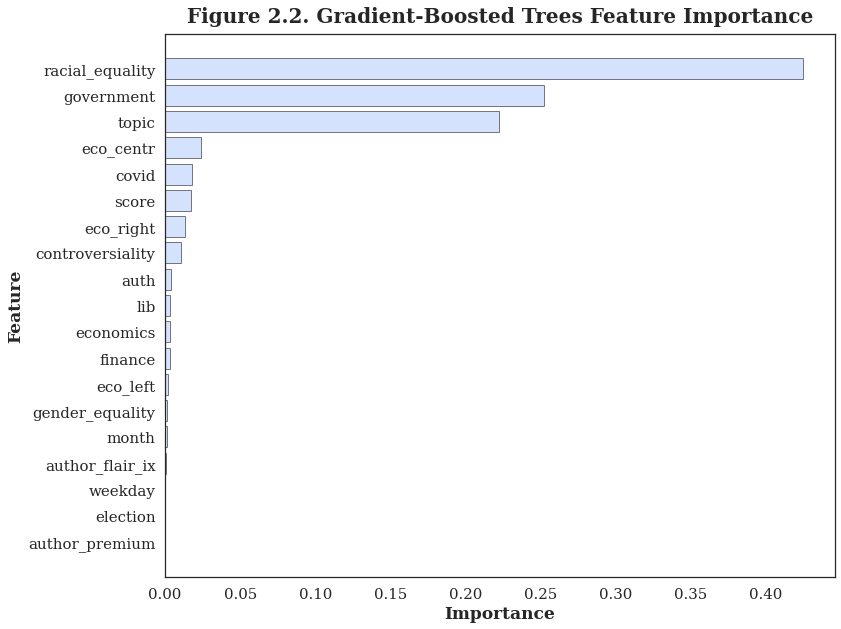

In [138]:
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})

fig, ax = plt.subplots(figsize=(12,10))
ax.barh(y = "feature", width = "importance", data = rf_feature_imp, edgecolor="black", color=pal[1], alpha=0.5)
ax.invert_yaxis()  

plt.title(label="Figure 2.2. Gradient-Boosted Trees Feature Importance", fontsize = 20, fontweight = "bold", y = 1.01)
plt.xlabel(xlabel = "Importance", fontsize = 17, fontweight = "bold")
plt.ylabel(ylabel = "Feature", fontsize = 17, fontweight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

### 2.4.4. Save Model

In [139]:
model_gbt1.write().overwrite().save("s3://yc910-labdata-4/models/gbt1")
model_gbt2.write().overwrite().save("s3://yc910-labdata-4/models/gbt2")
model_gbt3.write().overwrite().save("s3://yc910-labdata-4/models/gbt3")

### 2.5. Logistic Regression
### 2.5.1. Build a Pipeline and Train a Logistic Regression Model

In [140]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression

In [141]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [142]:
logit1 = LogisticRegression(labelCol="sentiment_ix", featuresCol="scaled_features", maxIter=100,threshold=0.5)
logit2 = LogisticRegression(labelCol="sentiment_ix", featuresCol="scaled_features", maxIter=200,threshold=0.5)
logit3 = LogisticRegression(labelCol="sentiment_ix", featuresCol="scaled_features", maxIter=200,threshold=0.45)

In [143]:
pipeline_logit1 = Pipeline(stages=[stringindexer_flair, 
                                   stringindexer_sentiment,  
                                   vectorAssembler_features, 
                                   scaler,
                                   logit1, 
                                   labelConverter])
pipeline_logit2 = Pipeline(stages=[stringindexer_flair, 
                                   stringindexer_sentiment,  
                                   vectorAssembler_features, 
                                   scaler,
                                   logit2, 
                                   labelConverter])
pipeline_logit3 = Pipeline(stages=[stringindexer_flair, 
                                   stringindexer_sentiment,  
                                   vectorAssembler_features, 
                                   scaler,
                                   logit3, 
                                   labelConverter])

In [144]:
model_logit1 = pipeline_logit1.fit(sub1_train)
model_logit1.transform(sub1_train)

22/04/27 04:10:19 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/27 04:10:19 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

In [145]:
model_logit2 = pipeline_logit2.fit(sub1_train)
model_logit2.transform(sub1_train)

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

In [146]:
model_logit3 = pipeline_logit3.fit(sub1_train)
model_logit3.transform(sub1_train)

DataFrame[author_flair_text: string, author_premium: int, controversiality: bigint, clean_text: string, sentiment: string, weekday: int, month: int, score: bigint, topic: int, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int, author_flair_ix: double, sentiment_ix: double, features: vector, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double, predicted_sentiment: string]

### 2.5.2. Model Evaluation and Comparison

In [147]:
logit_evaluation, logit_cm = model_eva([model_logit1, model_logit2, model_logit3], model_logit1, sub1_test, sub1_predict)

In [148]:
logit_evaluation.index = ["model1","model2","model3"]
logit_evaluation

,accuracy,f1,weighted_precision,weighted_recall,auc
model1,0.650394,0.558905,0.640038,0.650394,0.533095
model2,0.650394,0.558905,0.640038,0.650394,0.533095
model3,0.649588,0.566758,0.630817,0.649588,0.536613


In [149]:
print("Logistic Regression Confusion Matrix:")
print(logit_cm)

Logistic Regression Confusion Matrix:
[[ 1233 11145]
 [  740 20978]]


### 2.5.3. Feature Importance

In [150]:
logit_feature_imp = pd.DataFrame({"feature":model_logit1.stages[-4].getInputCols(), 
                               "importance":model_logit1.stages[-2].coefficients.toArray().tolist()})\
                                .sort_values("importance",ascending = False).reset_index(drop=True)

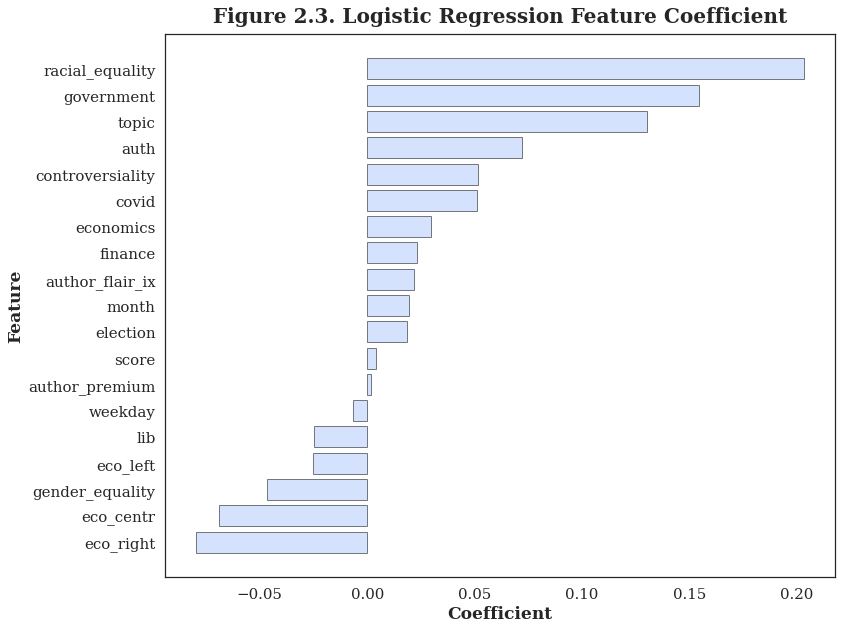

In [153]:
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})

fig, ax = plt.subplots(figsize=(12,10))
ax.barh(y = "feature", width = "importance", data = logit_feature_imp, edgecolor="black", color=pal[1], alpha=0.5)
ax.invert_yaxis()  

plt.title(label="Figure 2.3. Logistic Regression Feature Coefficient", fontsize = 20, fontweight = "bold", y = 1.01)
plt.xlabel(xlabel = "Coefficient", fontsize = 17, fontweight = "bold")
plt.ylabel(ylabel = "Feature", fontsize = 17, fontweight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

### 2.4.4. Save Model

In [154]:
model_logit1.write().overwrite().save("s3://yc910-labdata-4/models/logit1")
model_logit2.write().overwrite().save("s3://yc910-labdata-4/models/logit2")
model_logit3.write().overwrite().save("s3://yc910-labdata-4/models/logit3")

## 3. The Relation Between Nasdaq Index, Reddit Sentiments and COVID Cases
### 3.1. Data Preparation
### 3.1.1. Join External Data

In [155]:
df_covid = spark.read.csv("s3://yc910-labdata-4/covid")
df_covid = df_covid.selectExpr(
    '_c0 AS date',
    '_c1 AS new_case',
    '_c2 AS case_ma_7d',
    '_c3 AS total_case',
    '_c4 AS new_death',
    '_c5 AS death_ma_7d',
    '_c6 AS total_death')

In [156]:
df_covid.show(5)

+----------+--------+----------+----------+---------+-----------+-----------+
|      date|new_case|case_ma_7d|total_case|new_death|death_ma_7d|total_death|
+----------+--------+----------+----------+---------+-----------+-----------+
|2021-06-30|   17896|     13924|  33672298|      247|        234|     604321|
|2021-06-29|   16481|     13430|  33654402|      272|        243|     604074|
|2021-06-28|   10876|     13064|  33637921|      208|        246|     603802|
|2021-06-27|    9619|     12727|  33627045|      147|        254|     603594|
|2021-06-26|   12863|     12622|  33617426|      192|        261|     603447|
+----------+--------+----------+----------+---------+-----------+-----------+
only showing top 5 rows



In [157]:
df_nasdaq = spark.read.csv("s3://yc910-labdata-4/nasdaq")
df_nasdaq = df_nasdaq.selectExpr(
    '_c0 AS date',
    '_c1 AS close',
    '_c2 AS volumn'
)

In [158]:
df_nasdaq.show(5)

+----------+----------------+------+
|      date|           close|volumn|
+----------+----------------+------+
|2020-09-16|        11268.75|167828|
|2020-09-17|         11090.0|157390|
|2020-09-18|11144.8095703125|800279|
|2020-09-21|         10989.0|727984|
|2020-09-22|         11149.5|573572|
+----------+----------------+------+
only showing top 5 rows



In [159]:
df_external = df_covid.join(df_nasdaq, on="date", how="fullouter")

In [160]:
df_external.show(5)

+----------+--------+----------+----------+---------+-----------+-----------+-------+------+
|      date|new_case|case_ma_7d|total_case|new_death|death_ma_7d|total_death|  close|volumn|
+----------+--------+----------+----------+---------+-----------+-----------+-------+------+
|2019-08-15|    null|      null|      null|     null|       null|       null|7496.25|705042|
|2020-01-10|    null|      null|      null|     null|       null|       null|8978.25|472166|
|2020-01-22|    null|      null|      null|     null|       null|       null|9195.75|519015|
|2020-03-05|     165|       104|      1609|        3|          2|        257|8648.75|954104|
|2020-03-16|    2939|      1663|     14682|       21|         13|        368| 7057.5|307368|
+----------+--------+----------+----------+---------+-----------+-----------+-------+------+
only showing top 5 rows



In [161]:
df_external = df_external.filter(f.isnull("new_case")!=True)

In [162]:
df_external.count()

525

In [163]:
df_external = df_external.toPandas()

In [164]:
df_external.date = pd.to_datetime(df_external.date)

In [165]:
df_external[df_external.columns[1:]] = df_external[df_external.columns[1:]].astype("float")

df_external.sort_values(by = "date", ascending=True,inplace = True)

df_external.reset_index(drop=True, inplace=True)

df_external.isna().sum()

date             0
new_case         0
case_ma_7d       0
total_case       0
new_death        0
death_ma_7d      0
total_death      0
close          163
volumn         163
dtype: int64

### 3.1.2. Missing Data Imputation

In [166]:
def miss_impute(data_list):
    for i in range(len(data_list)):
            
        ## The last value is NA 
        if (i == len(data_list)-1) & (np.isnan(data_list[i]) == True): break
        
        ## In the middle
        if np.isnan(data_list[i]) == True: 
            pre = data_list[i-1]
            
            j=1
            while np.isnan(data_list[i+j]) == True: 
                j=j+1
                
            nex = data_list[i+j]
            
            slope = (nex-pre)/(j+1)
            data_list[i]=pre+slope
            
    return data_list

In [167]:
close = df_external.close.to_list()
volumn = df_external.volumn.to_list()

In [168]:
close_com = miss_impute(close)
volumn_com = miss_impute(volumn)

In [169]:
df_external[["close", "volumn"]] = pd.DataFrame({"close":close_com, "volumn": volumn_com})

df_external.dropna(inplace=True)

df_external.isna().sum()
#df_external.to_csv("df_external.csv",index=False)

date           0
new_case       0
case_ma_7d     0
total_case     0
new_death      0
death_ma_7d    0
total_death    0
close          0
volumn         0
dtype: int64

In [170]:
df_nasdaq = df_external

### 3.1.3. Reddit Data Aggregation

In [171]:
df_reddit = df_full.groupBy("date", "topic", "sentiment").agg(f.count("author"),
                                                                    f.sum("score"),
                                                                    f.sum("controversiality"),
                                                                    f.sum("covid"),
                                                                    f.sum("election"),
                                                                    f.sum("economics"),
                                                                    f.sum("finance"),
                                                                    f.sum("gender_equality"),
                                                                    f.sum("racial_equality"),
                                                                    f.sum("government")).toPandas()

In [172]:
df_reddit.columns = ["date","topic","sentiment","num_post", "tot_score", "tot_controversiality",
                        "covid","election","economics","finance","gender_equality","racial_equality","government"]
#df_date_senti.to_csv("reddit.csv", index=False)

In [173]:
df_nasdaq.dtypes

date           datetime64[ns]
new_case              float64
case_ma_7d            float64
total_case            float64
new_death             float64
death_ma_7d           float64
total_death           float64
close                 float64
volumn                float64
dtype: object

In [174]:
df_reddit.dtypes

date                    object
topic                    int32
sentiment               object
num_post                 int64
tot_score                int64
tot_controversiality     int64
covid                    int64
election                 int64
economics                int64
finance                  int64
gender_equality          int64
racial_equality          int64
government               int64
dtype: object

In [175]:
df_reddit.date = pd.to_datetime(df_reddit.date)

### 3.1.4. Create New Features

In [176]:
df_num_post = df_reddit[["date", "num_post"]].groupby("date").sum().reset_index()

df_num_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      729 non-null    datetime64[ns]
 1   num_post  729 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


In [177]:
df_sentiment = df_reddit[["date", "sentiment", "num_post"]].groupby(["date", "sentiment"]).sum().reset_index()

df_sentiment = df_sentiment[df_sentiment.sentiment != "neutral"]

df_sentiment = df_sentiment.pivot(index="date",columns="sentiment", values="num_post").reset_index()

df_sentiment["pos_neg_ratio"] = df_sentiment.positive / df_sentiment.negative

df_sentiment.drop(columns=["negative","positive"],inplace=True)

df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           729 non-null    datetime64[ns]
 1   pos_neg_ratio  729 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


In [178]:
df_score = df_reddit[["date", "num_post", "tot_score"]].groupby("date").sum().reset_index()

df_score["avg_score"] = df_score.tot_score / df_score.num_post

df_score.drop(columns=["num_post","tot_score"],inplace=True)

df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       729 non-null    datetime64[ns]
 1   avg_score  729 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


In [179]:
df_sen_score = df_reddit[["date","sentiment", "num_post", "tot_score"]].groupby(["date","sentiment"]).sum().reset_index()

df_sen_score = df_sen_score[df_sen_score.sentiment != "neutral"]

df_sen_score["sen_score"] = df_sen_score.tot_score / df_sen_score.num_post

df_sen_score.drop(columns=["num_post", "tot_score"], inplace=True)

df_sen_score = df_sen_score.pivot(index="date",columns="sentiment", values="sen_score").reset_index()

df_sen_score.rename(columns={"negative":"neg_score","positive":"pos_score"},inplace=True)

df_sen_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       729 non-null    datetime64[ns]
 1   neg_score  729 non-null    float64       
 2   pos_score  729 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 17.2 KB


In [180]:
df_red = df_num_post.merge(df_sentiment,on="date",how="left").merge(df_score,on="date",how="left").merge(df_sen_score,on="date",how="left")

df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           729 non-null    datetime64[ns]
 1   num_post       729 non-null    int64         
 2   pos_neg_ratio  729 non-null    float64       
 3   avg_score      729 non-null    float64       
 4   neg_score      729 non-null    float64       
 5   pos_score      729 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 39.9 KB


In [181]:
df = df_nasdaq.merge(df_red, on="date", how="left")

df = df[["date","close","new_case","new_death","volumn","num_post","pos_neg_ratio","avg_score","neg_score","pos_score"]]

df.head()

,date,close,new_case,new_death,volumn,num_post,pos_neg_ratio,avg_score,neg_score,pos_score
0,2020-01-23,9248.250000,1.0,0.0,616950.0,4699,2.201868,12.331986,10.879310,13.350408
1,2020-01-24,9144.500000,1.0,0.0,758796.0,4718,1.979320,17.801823,18.100067,17.795079
2,2020-01-25,9081.166667,0.0,0.0,770099.0,7333,1.889491,17.686077,17.118432,17.979695
3,2020-01-26,9017.833333,3.0,0.0,781402.0,11188,2.058483,17.690114,16.571801,17.958228
4,2020-01-27,8954.500000,0.0,0.0,792705.0,6502,2.241343,16.860812,13.624869,18.311096


In [182]:
df_train = df[df.date <= "2021-03-31"]
df_test = df[df.date > "2021-03-31"]

### 3.2. Packages Installation and Import

In [183]:
#!/mnt/miniconda/bin/pip install --upgrade --ignore-installed mxnet

In [184]:
#!/mnt/miniconda/bin/pip install --upgrade --ignore-installed tensorflow==2.8.0

In [185]:
#!/mnt/miniconda/bin/pip install --upgrade --ignore-installed tensorflow-gpu==2.8.0

In [186]:
#!/mnt/miniconda/bin/pip install --upgrade --ignore-installed keras

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.svm import SVR
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import time

### 3.3. Moving Average Estimation
### 3.3.1. Define a Function of MA

In [234]:
def stock_ma(df, window):
    df_train = df[df.date <= "2021-03-31"].close
    df_test = df[df.date > "2021-03-31"].close
    train_ma = []
    for i in range(window, len(df_train)):
        ma = sum(df_train[i-window:i])/window
        train_ma.append(ma)
    inputs = train_ma[len(train_ma)-window:]
    test_ma=[]
    for i in range(len(df_test)):
        ma = sum(inputs[i:i+window])/window
        inputs.append(ma)
        test_ma.append(ma)
    
    return train_ma, test_ma

In [235]:
train_ma_5, test_ma_5 = stock_ma(df, 5)
train_ma_15, test_ma_15 = stock_ma(df, 15)
train_ma_30, test_ma_30 = stock_ma(df, 30)

In [236]:
df_compare_ma_train = df_train[["date","close"]].reset_index(drop=True)
df_compare_ma_train["train_5"] = pd.DataFrame([np.nan]*5+train_ma_5)
df_compare_ma_train["train_15"] = pd.DataFrame([np.nan]*15+train_ma_15)
df_compare_ma_train["train_30"] = pd.DataFrame([np.nan]*30+train_ma_30)

In [237]:
df_compare_ma_pred = df_test[["date","close"]].reset_index(drop=True)
df_compare_ma_pred["test_5"] = pd.DataFrame(test_ma_5)
df_compare_ma_pred["test_15"] = pd.DataFrame(test_ma_15)
df_compare_ma_pred["test_30"] = pd.DataFrame(test_ma_30)

In [238]:
df_ma = pd.concat([pd.DataFrame(df_compare_ma_train.values), pd.DataFrame(df_compare_ma_pred.values)])
df_ma.columns = ["date","real","ma_5","ma_15","ma_30"]

In [239]:
from datetime import datetime

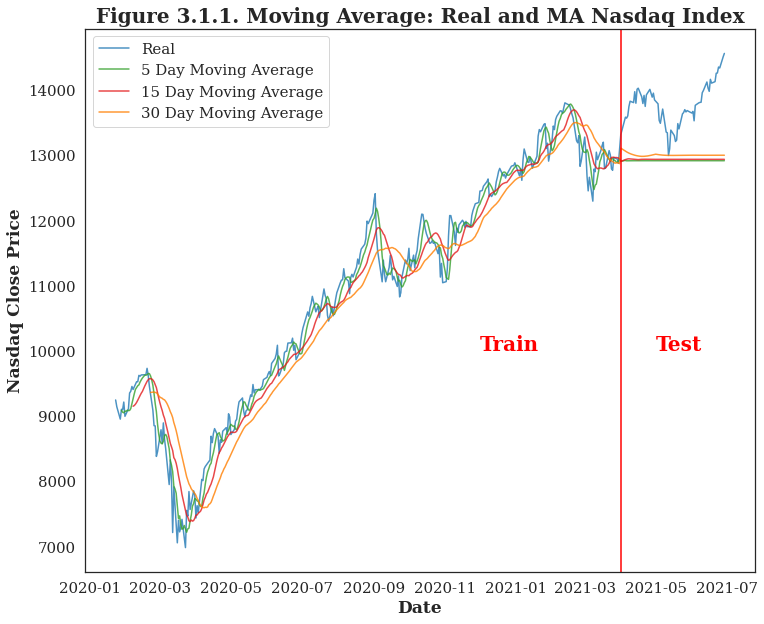

In [271]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_ma.columns[1:]:
    plt.plot("date", c, data=df_ma, color = pal[i], alpha=0.8)
    i+=1
    
plt.axvline(x = datetime.strptime("2021-04-01", "%Y-%m-%d"), color = 'red')
plt.text(x=datetime.strptime("2021-05-01", "%Y-%m-%d"), y=10000, s="Test", fontsize=20, fontweight="bold", color = "red")
plt.text(x=datetime.strptime("2020-12-01", "%Y-%m-%d"), y=10000, s="Train", fontsize=20, fontweight="bold", color = "red")
# Add legend
plt.title("Figure 3.1.1. Moving Average: Real and MA Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "5 Day Moving Average", "15 Day Moving Average", "30 Day Moving Average"],
           loc=2, ncol=1, fontsize=15)

plt.show()

### 3.3.2. Evaluate on Training Set

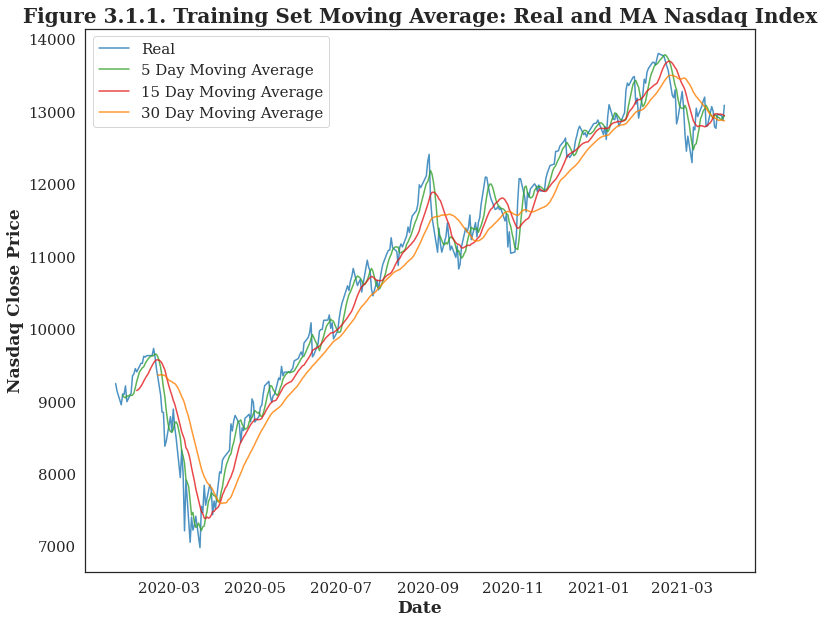

In [192]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_compare_ma_train.columns[1:]:
    plt.plot("date", c, data=df_compare_ma_train, color = pal[i], alpha=0.8)
    i+=1
    
    
# Add legend
plt.title("Figure 3.1.2. Training Set Moving Average: Real and MA Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "5 Day Moving Average", "15 Day Moving Average", "30 Day Moving Average"],
           loc=2, ncol=1, fontsize=15)

plt.show()

### 3.3.3. Evaluate on Test Set

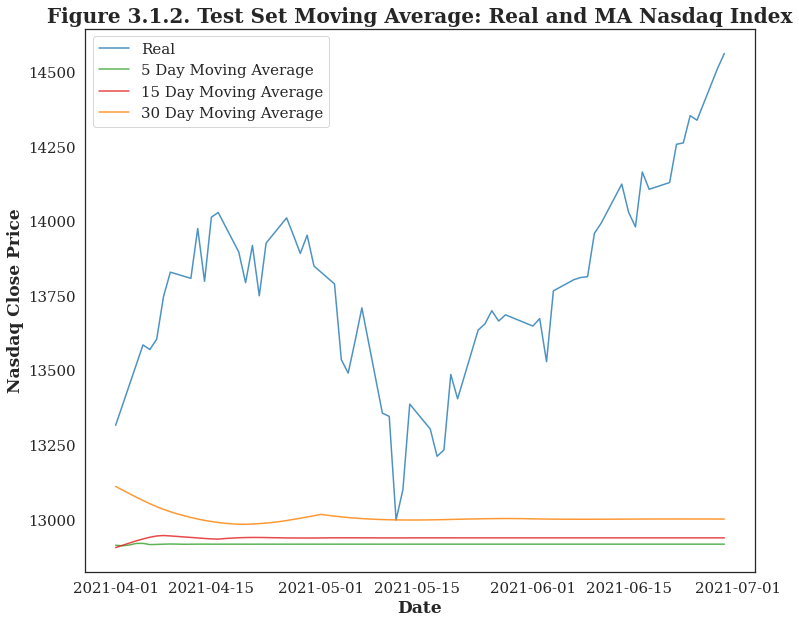

In [194]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_compare_ma_pred.columns[1:]:
    plt.plot("date", c, data=df_compare_ma_pred, color = pal[i], alpha=0.8)
    i+=1

    
# Add legend
plt.title("Figure 3.1.3. Test Set Moving Average: Real and MA Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "5 Day Moving Average", "15 Day Moving Average", "30 Day Moving Average"],
           loc=2, ncol=1, fontsize=15)

plt.show()

### 3.3.4. Evaluation Metrics

In [195]:
r2_list = []
rmse_train_list = []
for i in [5,15,30]:
    r2 = r2_score(df_compare_ma_train["close"][i:], df_compare_ma_train["train_"+str(i)][i:])
    r2_list.append(r2)
    
    rmse = np.sqrt(mean_squared_error(df_compare_ma_train["close"][i:], df_compare_ma_train["train_"+str(i)][i:]))
    rmse_train_list.append(rmse)

In [196]:
mape_list = []
rmse_test_list = []

for i in [5,15,30]:
    mape = mean_absolute_percentage_error(df_compare_ma_pred["close"], df_compare_ma_pred["test_"+str(i)])
    mape_list.append(mape)
    
    rmse = np.sqrt(mean_squared_error(df_compare_ma_pred["close"], df_compare_ma_pred["test_"+str(i)]))
    rmse_test_list.append(rmse)

In [197]:
df_ma_eva = pd.DataFrame({"Train_R_Squared": r2_list, "Train_RMSE": rmse_train_list, "Test_RMSE": rmse_test_list, "Test_MAPE": mape_list})

df_ma_eva.index=["Ma_5","Ma_15","Ma_30"]

df_ma_eva

,Train_R_Squared,Train_RMSE,Test_RMSE,Test_MAPE
Ma_5,0.984901,216.094369,921.207135,0.062286
Ma_15,0.963555,335.606992,901.664790,0.060800
Ma_30,0.926160,480.626418,839.987705,0.055749


### 3.4. SVR
### 3.4.1. Define a Function of SVR

In [198]:
def stock_svr(df, kernel="poly", max_iter=-1):
    print("Kernel:", kernel, "\nStart training")
    start_time = time.time()
    df_train = df[df.date <= "2021-03-31"]
    df_test = df[df.date > "2021-03-31"]
    
    sc=MinMaxScaler(feature_range=(0,1))
    train_scale = sc.fit_transform(df_train.iloc[:,1:])
    test_scale = sc.transform(df_test.iloc[:,1:])

    svr = SVR(kernel=kernel, max_iter=max_iter)
    svr.fit(X = train_scale[:,1:], y = train_scale[:,0])
    
    pred = svr.predict(X = test_scale[:,1:])
    pred_train = svr.predict(X = train_scale[:,1:])
    
    
    df_pred = pd.DataFrame(test_scale)
    df_pred[0] = pd.DataFrame(pred)
    pred_array = df_pred.values
    predicted_stock_price = sc.inverse_transform(pred_array)
    
    
    df_train_pred = pd.DataFrame(train_scale)
    df_train_pred[0] = pd.DataFrame(pred_train)
    pred_train_array = df_train_pred.values
    predicted_train = sc.inverse_transform(pred_train_array)
    
    end_time = time.time()
    print("Finish training, time consumed:", end_time-start_time, "\n")
    
    
    return predicted_train[:,0], predicted_stock_price[:,0]

In [199]:
train_svr_poly, test_svr_poly = stock_svr(df, "poly")
train_svr_linear, test_svr_linear = stock_svr(df, "linear")
train_svr_rbf, test_svr_rbf = stock_svr(df, "rbf")

Kernel: poly 
Start training
Finish training, time consumed: 0.5194516181945801 

Kernel: linear 
Start training
Finish training, time consumed: 0.02471923828125 

Kernel: rbf 
Start training
Finish training, time consumed: 0.02962946891784668 



In [257]:
df_compare_svr_train = df_train[["date","close"]].reset_index(drop=True)
df_compare_svr_train["train_poly"] = pd.DataFrame(train_svr_poly)
df_compare_svr_train["train_linear"] = pd.DataFrame(train_svr_linear)
df_compare_svr_train["train_rbf"] = pd.DataFrame(train_svr_rbf)

In [258]:
df_compare_svr_test = df_test[["date","close"]].reset_index(drop=True)
df_compare_svr_test["test_poly"] = pd.DataFrame(test_svr_poly)
df_compare_svr_test["test_linear"] = pd.DataFrame(test_svr_linear)
df_compare_svr_test["test_rbf"] = pd.DataFrame(test_svr_rbf)

In [259]:
df_svr = pd.concat([pd.DataFrame(df_compare_svr_train.values), pd.DataFrame(df_compare_svr_test.values)])
df_svr.columns = ["date","real","poly","linear","rbf"]

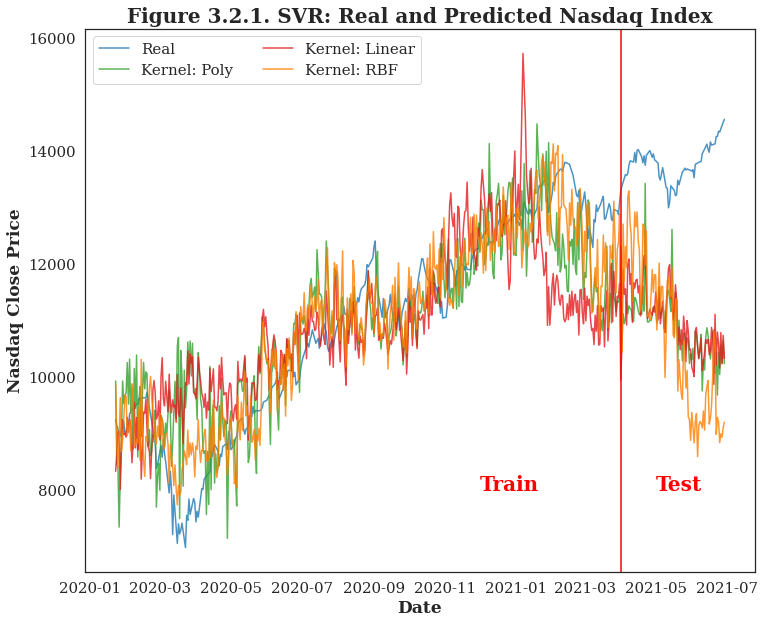

In [270]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_svr.columns[1:]:
    plt.plot("date", c, data=df_svr, color = pal[i], alpha=0.8)
    i+=1
    
plt.axvline(x = datetime.strptime("2021-04-01", "%Y-%m-%d"), color = 'red')
plt.text(x=datetime.strptime("2021-05-01", "%Y-%m-%d"), y=8000, s="Test", fontsize=20, fontweight="bold", color = "red")
plt.text(x=datetime.strptime("2020-12-01", "%Y-%m-%d"), y=8000, s="Train", fontsize=20, fontweight="bold", color = "red")

# Add legend
plt.title("Figure 3.2.1. SVR: Real and Predicted Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "Kernel: Poly", "Kernel: Linear", "Kernel: RBF"],
           loc=2, ncol=2, fontsize=15)

plt.show()

### 3.4.2. Compare Different Model - Training Set

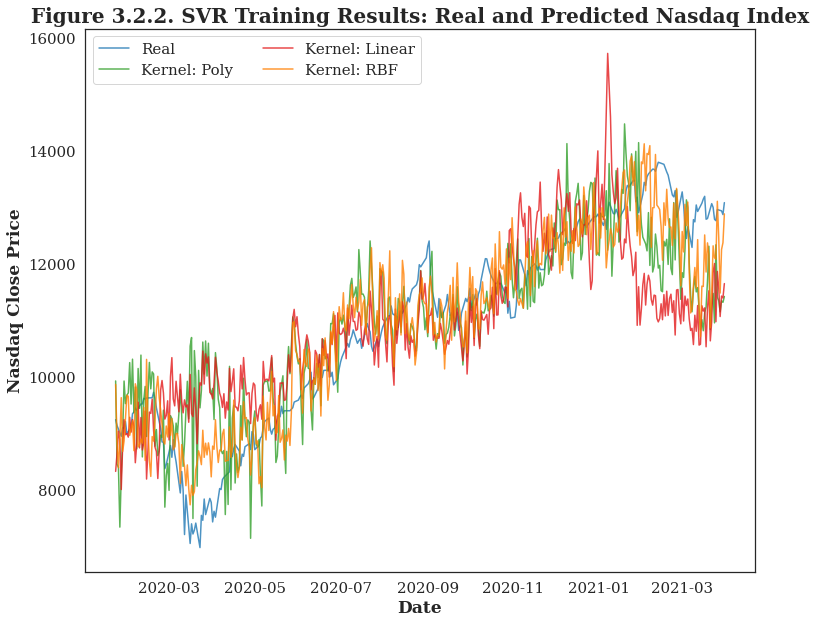

In [262]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_compare_svr_train.columns[1:]:
    plt.plot("date", c, data=df_compare_svr_train, color = pal[i], alpha=0.8)
    i+=1
    
    
# Add legend
plt.title("Figure 3.2.2. SVR Training Results: Real and Predicted Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "Kernel: Poly", "Kernel: Linear", "Kernel: RBF"],
           loc=2, ncol=2, fontsize=15)

plt.show()

### 3.4.3. Compare Different Model - Test Set

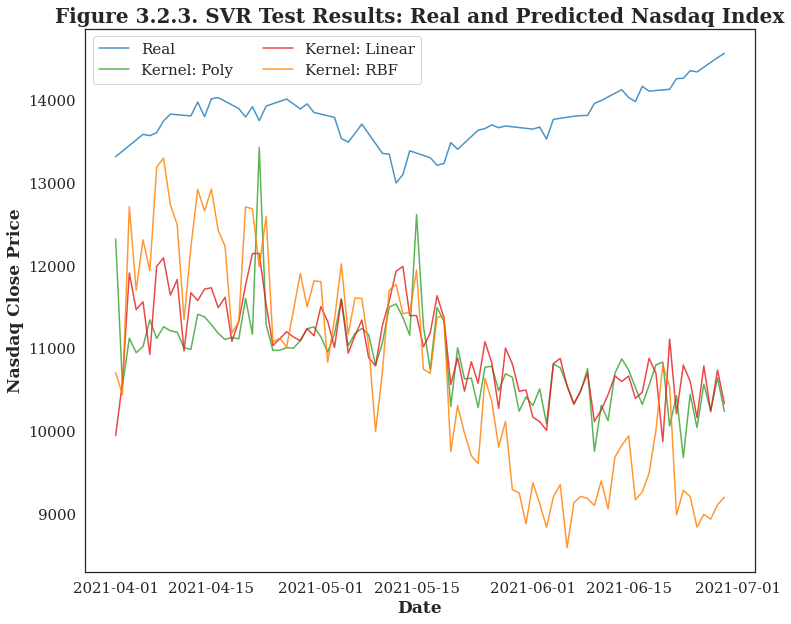

In [263]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_compare_svr_test.columns[1:]:
    plt.plot("date", c, data=df_compare_svr_test, color = pal[i], alpha=0.8)
    i+=1

    
# Add legend
plt.title("Figure 3.2.3. SVR Test Results: Real and Predicted Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "Kernel: Poly", "Kernel: Linear", "Kernel: RBF"],
           loc=2, ncol=2, fontsize=15)

plt.show()

### 3.4.4. Evaluation Metrics

In [204]:
r2_list = []
rmse_train_list = []
for i in ["poly","linear","rbf"]:
    r2 = r2_score(df_compare_svr_train["close"], df_compare_svr_train["train_"+i])
    r2_list.append(r2)
    
    rmse = np.sqrt(mean_squared_error(df_compare_svr_train["close"], df_compare_svr_train["train_"+i]))
    rmse_train_list.append(rmse)

In [205]:
mape_list = []
rmse_test_list = []

for i in ["poly","linear","rbf"]:
    mape = mean_absolute_percentage_error(df_compare_svr_test["close"], df_compare_svr_test["test_"+i])
    mape_list.append(mape)
    
    rmse = np.sqrt(mean_squared_error(df_compare_svr_test["close"], df_compare_svr_test["test_"+i]))
    rmse_test_list.append(rmse)

In [206]:
df_svr_eva = pd.DataFrame({"Train_R_Squared": r2_list, "Train_RMSE": rmse_train_list, "Test_RMSE": rmse_test_list, "Test_MAPE": mape_list})

df_svr_eva.index=["Kernel_poly","Kernel_linear","Kernel_rbf"]

df_svr_eva

,Train_R_Squared,Train_RMSE,Test_RMSE,Test_MAPE
Kernel_poly,0.686021,985.998560,2969.843402,0.207838
Kernel_linear,0.554688,1174.243856,2869.145697,0.200752
Kernel_rbf,0.852834,675.040360,3389.888787,0.221824


### 3.5. LSTM
### 3.5.1. Define a Function of LSTM with Lookback

In [77]:
np.random.seed(502)
tf.random.set_seed(502)

def stock_pred(df, lag, epoch_size, batch_size):
    print("Look Back:", lag, "\nStart training")
    start_time = time.time()
    df_train = df[df.date <= "2021-03-31"]
    df_test = df[df.date > "2021-03-31"]
    
    sc = MinMaxScaler(feature_range=(0,1))
    
    train = df_train.iloc[:,1:].values
    train_scaled = sc.fit_transform(train)
    
    X_train = []
    y_train = []
    for i in range(lag, len(df_train)):
        X_train.append(train_scaled[i-lag:i, :])
        y_train.append(train_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    
    model = Sequential()
    model.add(LSTM(units=50,
                   return_sequences=True,
                   #batch_input_shape=(batch_size, lag, 9),stateful=True
                   input_shape=(X_train.shape[1], X_train.shape[2]), 
                   ))
    #model.add(LSTM(units=50,return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    """
    model.fit(X_train[:X_train.shape[0]-60,:,:],y_train[:X_train.shape[0]-60],
              validation_data=(X_train[X_train.shape[0]-60:,:,:],y_train[X_train.shape[0]-60:]),
              epochs=epoch_size,batch_size=batch_size, 
              use_multiprocessing=True, verbose=1, callbacks=[callback])
    """
    model.fit(X_train,y_train,
              epochs=epoch_size,batch_size=batch_size, 
              use_multiprocessing=True, verbose=0, callbacks=[callback])
    
    
    df_inputs = df.drop(columns="date")
    inputs = df_inputs[len(df_inputs) - len(df_test) - lag:].values
    inputs_scaled = sc.transform(inputs)
    
    X_test = []
    for i in range(lag, inputs.shape[0]):
        X_test.append(inputs_scaled[i-lag:i, :])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    
    predicted_stock_price = model.predict(X_test)
    df_pred = pd.DataFrame(X_test[:,0])
    #df_pred.insert(loc=0,column="close",value=pd.DataFrame(predicted_stock_price))
    df_pred[0] = pd.DataFrame(predicted_stock_price)
    pred_array = df_pred.values
    predicted_stock_price = sc.inverse_transform(pred_array)
    
    
    predicted_train = model.predict(X_train)
    df_train_pred = pd.DataFrame(X_train[:,0])
    #df_train_pred.insert(loc=0,column="close",value=pd.DataFrame(predicted_train))
    df_train_pred[0] = pd.DataFrame(predicted_train)
    pred_train_array = df_train_pred.values
    
    predicted_train = sc.inverse_transform(pred_train_array)
    end_time = time.time()
    print("Finish training, time consumed:", end_time-start_time, "\n")
    
    
    return predicted_train[:,0], predicted_stock_price[:,0]

In [78]:
train_pred_15, pred_15 = stock_pred(df, 15, 30, 4)
train_pred_30, pred_30 = stock_pred(df, 30, 30, 4)
train_pred_60, pred_60 = stock_pred(df, 60, 30, 4)
train_pred_90, pred_90 = stock_pred(df, 90, 30, 4)
train_pred_120, pred_120 = stock_pred(df, 120, 30, 4)

Look Back: 15 
Start training


2022-04-27 03:07:31.425585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 03:07:31.425616: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 03:07:31.425637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-40-234): /proc/driver/nvidia/version does not exist
2022-04-27 03:07:31.425848: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Finish training, time consumed: 19.0404269695282 

Look Back: 30 
Start training
Finish training, time consumed: 15.882042407989502 

Look Back: 60 
Start training
Finish training, time consumed: 107.75452470779419 

Look Back: 90 
Start training
Finish training, time consumed: 113.48526692390442 

Look Back: 120 
Start training
Finish training, time consumed: 86.10148096084595 



In [264]:
df_compare_train = df_train[["date","close"]].reset_index(drop=True)
df_compare_train["train_pred_15"] = pd.DataFrame([np.nan]*15+list(train_pred_15))
df_compare_train["train_pred_30"] = pd.DataFrame([np.nan]*30+list(train_pred_30))
df_compare_train["train_pred_60"] = pd.DataFrame([np.nan]*60+list(train_pred_60))
df_compare_train["train_pred_90"] = pd.DataFrame([np.nan]*90+list(train_pred_90))
df_compare_train["train_pred_120"] = pd.DataFrame([np.nan]*120+list(train_pred_120))

In [265]:
df_compare_pred = df_test[["date","close"]].reset_index(drop=True)
df_compare_pred["pred_15"] = pd.DataFrame(pred_15)
df_compare_pred["pred_30"] = pd.DataFrame(pred_30)
df_compare_pred["pred_60"] = pd.DataFrame(pred_60)
df_compare_pred["pred_90"] = pd.DataFrame(pred_90)
df_compare_pred["pred_120"] = pd.DataFrame(pred_120)

In [266]:
df_lstm = pd.concat([pd.DataFrame(df_compare_train.values), pd.DataFrame(df_compare_pred.values)])
df_lstm.columns = ["date","real","lb_15","lb_30","lb_60","lb_90","lb_120"]

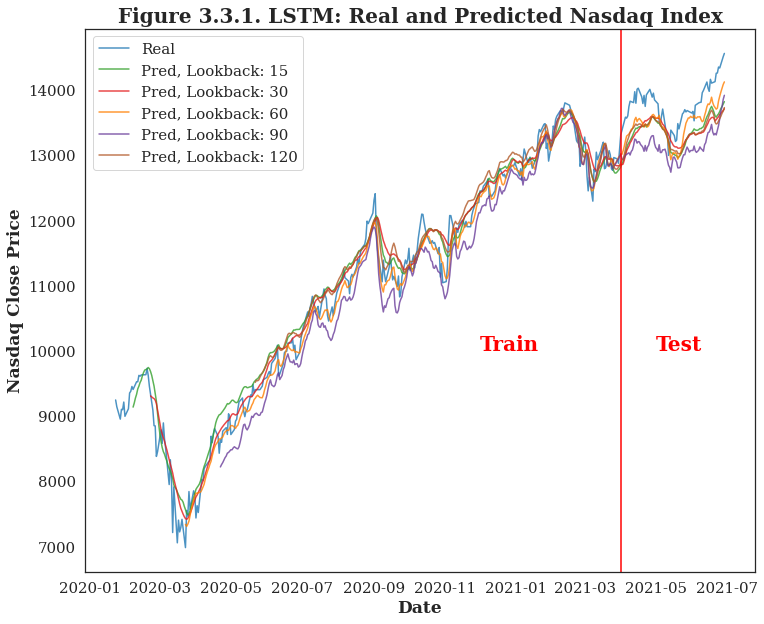

In [272]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_lstm.columns[1:]:
    plt.plot("date", c, data=df_lstm, color = pal[i], alpha=0.8)
    i+=1

plt.axvline(x = datetime.strptime("2021-04-01", "%Y-%m-%d"), color = 'red')
plt.text(x=datetime.strptime("2021-05-01", "%Y-%m-%d"), y=10000, s="Test", fontsize=20, fontweight="bold", color = "red")
plt.text(x=datetime.strptime("2020-12-01", "%Y-%m-%d"), y=10000, s="Train", fontsize=20, fontweight="bold", color = "red")
    
# Add legend
plt.title("Figure 3.3.1. LSTM: Real and Predicted Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "Pred, Lookback: 15", 
                   "Pred, Lookback: 30", "Pred, Lookback: 60", 
                   "Pred, Lookback: 90", "Pred, Lookback: 120"],
           loc=2, ncol=1, fontsize=15)

plt.show()

### 3.5.2. Compare Different Lookback Period - Train Set

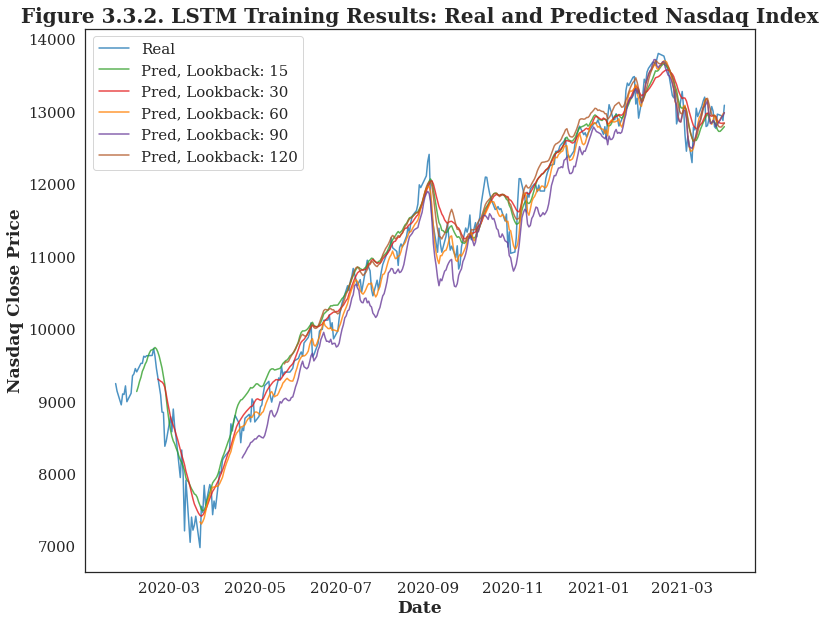

In [273]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_compare_train.columns[1:]:
    plt.plot("date", c, data=df_compare_train, color = pal[i], alpha=0.8)
    i+=1
    
    
# Add legend
plt.title("Figure 3.3.2. LSTM Training Results: Real and Predicted Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "Pred, Lookback: 15", 
                   "Pred, Lookback: 30", "Pred, Lookback: 60", 
                   "Pred, Lookback: 90", "Pred, Lookback: 120"],
           loc=2, ncol=1, fontsize=15)

plt.show()

### 3.5.3. Compare Different Lookback Period - Train Set

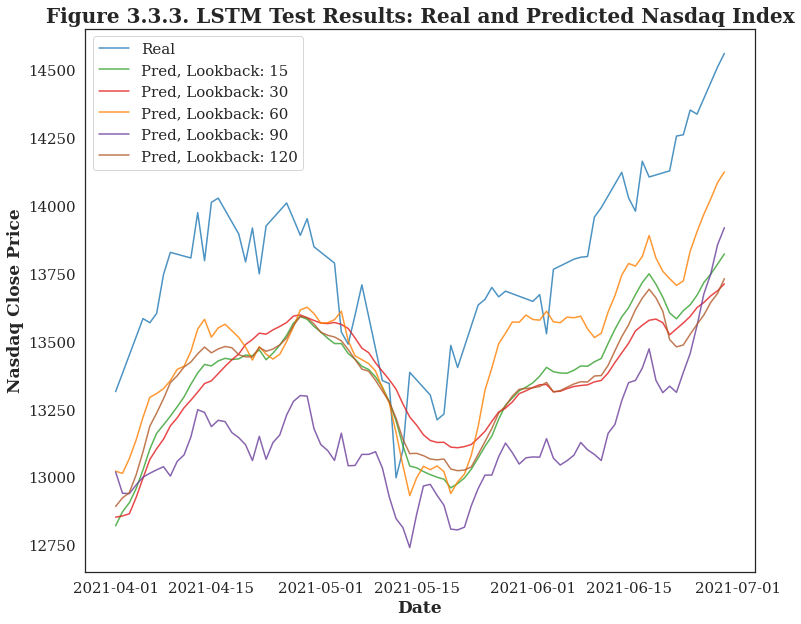

In [274]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
pal = sns.color_palette(palette="Paired", n_colors=13)[1::2] ## Generate a palette

i=0
for c in df_compare_pred.columns[1:]:
    plt.plot("date", c, data=df_compare_pred, color = pal[i], alpha=0.8)
    i+=1

    
# Add legend
plt.title("Figure 3.3.3. LSTM Test Results: Real and Predicted Nasdaq Index", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Date', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Nasdaq Close Price', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels=["Real", "Pred, Lookback: 15", 
                   "Pred, Lookback: 30", "Pred, Lookback: 60", 
                   "Pred, Lookback: 90", "Pred, Lookback: 120"],
           loc=2, ncol=1, fontsize=15)

plt.show()

### 3.5.4. Evaluation Metrics

In [275]:
r2_list = []
rmse_train_list = []
for i in [15,30,60,90,120]:
    r2 = r2_score(df_compare_train["close"][i:], df_compare_train["train_pred_"+str(i)][i:])
    r2_list.append(r2)
    
    rmse = np.sqrt(mean_squared_error(df_compare_train["close"][i:], df_compare_train["train_pred_"+str(i)][i:]))
    rmse_train_list.append(rmse)

In [276]:
mape_list = []
rmse_test_list = []

for i in [15,30,60,90,120]:
    mape = mean_absolute_percentage_error(df_compare_pred["close"], df_compare_pred["pred_"+str(i)])
    mape_list.append(mape)
    
    rmse = np.sqrt(mean_squared_error(df_compare_pred["close"], df_compare_pred["pred_"+str(i)]))
    rmse_test_list.append(rmse)

In [277]:
df_lstm_eva = pd.DataFrame({"Train_R_Squared": r2_list, "Train_RMSE": rmse_train_list, "Test_RMSE": rmse_test_list, "Test_MAPE": mape_list})

df_lstm_eva.index=["Lookback_15","Lookback_30","Lookback_60","Lookback_90","Lookback_120"]

df_lstm_eva

,Train_R_Squared,Train_RMSE,Test_RMSE,Test_MAPE
Lookback_15,0.979173,253.699928,453.341848,0.030459
Lookback_30,0.980376,247.774331,476.266867,0.031126
Lookback_60,0.988089,176.628003,344.532034,0.022674
Lookback_90,0.948534,308.526881,667.797575,0.046733
Lookback_120,0.960603,230.319080,462.438034,0.030572


In [85]:
spark.stop()